# EHMT1: Kleefstra Syndrome

**Kleefstra Syndrome (OMIM #610253)**, a rare developmental disorder caused by pathogenic variants in the *EHMT1* gene, is characterized by a range of symptoms including severe mental retardation, hypotonia, brachy(micro)cephaly, epileptic seizures, flat face with hypertelorism, synophrys, anteverted nares, everted lower lip, carp mouth with macroglossia, and heart defects. 

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


# EHMT1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for EHMT1.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'EHMT1'
mane_tx_id = 'NM_024757.5'
mane_protein_id = 'NP_079033.4'
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets


phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets (
   phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 125/125 [00:51<00:00,  2.41 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
114,Global developmental delay
112,Intellectual disability
59,Chronic constipation
55,Autism
52,Recurrent infections
49,Hypotonia
41,Hypermetropia
39,Overweight
35,Developmental regression
35,Hearing impairment


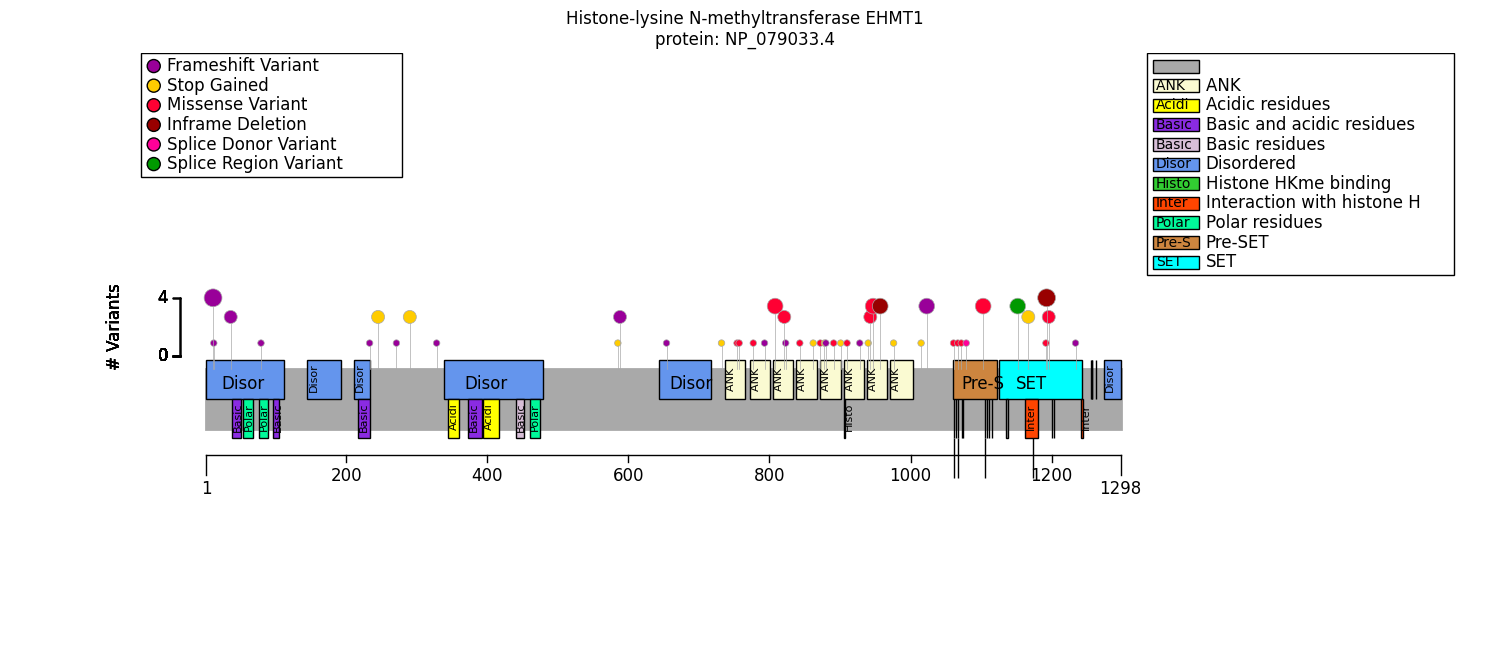

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

ehmt1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
ehmt1_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort)

Count,Name,Type,Coordinates,Variants
8,Disordered,Region,2 - 111,p.Glu14SerfsTer8; p.Gln82ArgfsTer7; p.Arg12ThrfsTer25; p.Glu14GlyfsTer23; p.Gly37ValfsTer17
0,Basic and acidic residues,Compositional bias,39 - 50,
0,Polar residues,Compositional bias,55 - 67,
1,Polar residues,Compositional bias,77 - 89,p.Gln82ArgfsTer7
0,Basic and acidic residues,Compositional bias,97 - 105,
0,Disordered,Region,145 - 192,
1,Disordered,Region,212 - 234,p.Glu236ArgfsTer47
1,Basic and acidic residues,Compositional bias,218 - 234,p.Glu236ArgfsTer47
0,Disordered,Region,340 - 479,
0,Acidic residues,Compositional bias,345 - 360,


In [7]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
40,SO:1000029_HGNC:24650_EHMT1,SV involving EHMT1 (p.?),,chromosomal deletion
3,9_137813009_137813015_CTTTCTT_C,c.2873_2878del (p.Phe958_Leu959del),20,inframe deletion
3,SO:1000037_HGNC:24650_EHMT1,SV involving EHMT1 (p.?),,chromosomal duplication
3,9_137790891_137790891_C_T,c.2426C>T (p.Pro809Leu),16,missense
3,9_137815998_137815998_G_A,c.3310G>A (p.Glu1104Lys),23,missense
3,9_137813421_137813423_CCT_C,c.3072_3073del (p.Val1026GlnfsTer150),21,frameshift
3,9_137811590_137811590_C_T,c.2842C>T (p.Arg948Trp),19,missense
2,9_137834389_137834401_ACGTCAGCCGGTT_A,c.3583_3594del (p.Val1195_Phe1198del),26,inframe deletion
2,9_137834389_137834389_A_T,c.3581A>T (p.Asn1194Ile),26,missense
2,9_137716649_137716649_G_AT,c.109_110insT (p.Gly37ValfsTer17),3,frameshift


# Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
analysis = configure_hpo_term_analysis(hpo)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label='Missense', 
    b_label='Other'
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_viewer.process(missense_result)

Reason,Count
"Skipping ""general"" level terms",52
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),101


In [10]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, missense_result)

Allele group,Missense,Other,Corrected p values,p values
Recurrent infections [HP:0002719],9/12 (75%),49/50 (98%),0.947609,0.020606
Gastroesophageal reflux [HP:0002020],2/24 (8%),27/90 (30%),0.947609,0.034927
Hearing impairment [HP:0000365],4/23 (17%),31/74 (42%),0.947609,0.045852
Ventricular septal defect [HP:0001629],0/25 (0%),10/84 (12%),1.000000,0.112415
Microcephaly [HP:0000252],3/25 (12%),22/77 (29%),1.000000,0.113924
...,...,...,...,...
Recurrent maladaptive behavior [HP:5200241],8/8 (100%),43/43 (100%),1.000000,1.000000
Autistic behavior [HP:0000729],9/9 (100%),46/46 (100%),1.000000,1.000000
Diagnostic behavioral phenotype [HP:0025783],9/9 (100%),46/46 (100%),1.000000,1.000000
Unusual infection [HP:0032101],9/9 (100%),49/49 (100%),1.000000,1.000000


In [11]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Pectus excavatum [HP:0000767],2/81 (2%),6/44 (14%),0.700236,0.022235
Patent foramen ovale [HP:0001655],1/75 (1%),4/41 (10%),0.700236,0.052027
Recurrent urinary tract infections [HP:0000010],6/77 (8%),0/42 (0%),0.700236,0.088712
Developmental regression [HP:0002376],27/81 (33%),8/44 (18%),0.700236,0.095207
Renal cyst [HP:0000107],0/75 (0%),2/40 (5%),0.700236,0.118993
...,...,...,...,...
Atypical behavior [HP:0000708],59/59 (100%),23/23 (100%),1.000000,1.000000
Neurodevelopmental delay [HP:0012758],73/73 (100%),41/41 (100%),1.000000,1.000000
Global developmental delay [HP:0001263],73/80 (91%),41/44 (93%),1.000000,1.000000
Neurodevelopmental abnormality [HP:0012759],77/77 (100%),42/42 (100%),1.000000,1.000000


In [12]:
from gpsea.analysis.predicate import exon, anyof, allof
exon1 = exon(exon=1, tx_id=mane_tx_id)
exon2 = exon(exon=2, tx_id=mane_tx_id)
exon3 = exon(exon=3, tx_id=mane_tx_id)
frameshift = variant_effect(effect=VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)

n_term = anyof((exon1, exon2, exon3))
n_term_fs = allof((n_term, frameshift))

n_term_fs_clf = monoallelic_classifier(
    a_predicate=n_term_fs,
    b_predicate=~n_term_fs,
    a_label="N Term Frameshift",
    b_label="other"
)
n_term_fs_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=n_term_fs_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, n_term_fs_result)

Allele group,N Term Frameshift,other,Corrected p values,p values
Attention deficit hyperactivity disorder [HP:0007018],4/8 (50%),3/96 (3%),0.028978,0.000483
Intellectual disability [HP:0001249],4/8 (50%),108/117 (92%),0.121026,0.004034
Global developmental delay [HP:0001263],4/7 (57%),110/117 (94%),0.194767,0.011330
Chronic constipation [HP:0012450],0/7 (0%),59/112 (53%),0.194767,0.012984
Obesity [HP:0001513],3/6 (50%),10/103 (10%),0.262215,0.021851
Anxiety [HP:0000739],4/8 (50%),22/96 (23%),1.000000,0.105109
Depression [HP:0000716],2/8 (25%),7/96 (7%),1.000000,0.141993
Hypotonia [HP:0001252],1/8 (12%),48/117 (41%),1.000000,0.146928
Clinodactyly of the 5th finger [HP:0004209],1/8 (12%),2/117 (2%),1.000000,0.181338
Gastroesophageal reflux [HP:0002020],0/7 (0%),29/107 (27%),1.000000,0.188292


In [13]:
ablation = variant_effect(effect=VariantEffect.TRANSCRIPT_ABLATION, tx_id=mane_tx_id)

ablation_clf = monoallelic_classifier(
    a_predicate=ablation,
    b_predicate=~ablation,
    a_label="CNV",
    b_label="other"
)
ablation_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ablation_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, ablation_result)

Allele group,CNV,other,Corrected p values,p values
Microcephaly [HP:0000252],15/26 (58%),10/76 (13%),0.001190,0.000019
Chronic constipation [HP:0012450],27/39 (69%),32/80 (40%),0.105686,0.003409
Ventricular septal defect [HP:0001629],7/36 (19%),3/73 (4%),0.293679,0.014210
Talipes equinovarus [HP:0001762],4/40 (10%),1/85 (1%),0.501187,0.035928
Tube feeding [HP:0033454],6/37 (16%),3/74 (4%),0.501187,0.057790
...,...,...,...,...
Atypical behavior [HP:0000708],25/25 (100%),57/57 (100%),1.000000,1.000000
Constipation [HP:0002019],27/27 (100%),32/32 (100%),1.000000,1.000000
Abdominal symptom [HP:0011458],30/30 (100%),49/49 (100%),1.000000,1.000000
Neurodevelopmental delay [HP:0012758],38/38 (100%),76/76 (100%),1.000000,1.000000


# 
The eight individuals with a PAV in the ANKR domain had a higher IQ (mean IQ 65 vs. 54, p = 0.03). Furthermore, feeding difficulties were significantly less prevalent (3/20 vs. 20/47, p = 0.03), as well as structural heart defects (2/20 vs. 15/47, p = 0.06), and recurrent infections had a lower prevalence (6/20 vs. 27/47, p = 0.04). Similarly, the five individuals with a PAV in the SET domain also had a higher IQ (mean IQ 66 vs. 54, p = 0.04) and lower prevalence of recurrent infections (3/13 vs. 27/47, p = 0.03) (Figure S6).

In [14]:
from gpsea.analysis.predicate import protein_feature
## ankyrin repeat (ANK) domain
ank1 = protein_feature(feature_id="ANK 1", protein_metadata=protein_meta) #737 - 766	
ank2 = protein_feature(feature_id="ANK 2", protein_metadata=protein_meta) #772 - 801
ank3 = protein_feature(feature_id="ANK 3", protein_metadata=protein_meta) #805 - 834
ank4 = protein_feature(feature_id="ANK 4", protein_metadata=protein_meta) #838 - 868
ank5 = protein_feature(feature_id="ANK 5", protein_metadata=protein_meta) #872 - 901
ank6 = protein_feature(feature_id="ANK 6", protein_metadata=protein_meta) #905 - 934	

ank_repeat = anyof((ank1, ank2, ank3, ank4, ank5, ank6))

ank_repeat_clf = monoallelic_classifier(
    a_predicate=ank_repeat,
    b_predicate=~ank_repeat,
    a_label="ANKR",
    b_label="other"
)

ank_repeat_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ank_repeat_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, ank_repeat_result)

Allele group,ANKR,other,Corrected p values,p values
Febrile seizure (within the age range of 3 months to 6 years) [HP:0002373],3/18 (17%),3/100 (3%),1.0,0.044905
Microcephaly [HP:0000252],1/18 (6%),24/84 (29%),1.0,0.065917
Tube feeding [HP:0033454],3/16 (19%),6/95 (6%),1.0,0.120169
Recurrent infections [HP:0002719],11/13 (85%),47/49 (96%),1.0,0.190836
Small for gestational age [HP:0001518],4/16 (25%),8/76 (11%),1.0,0.211860
...,...,...,...,...
Recurrent maladaptive behavior [HP:5200241],7/7 (100%),44/44 (100%),1.0,1.000000
Constipation [HP:0002019],7/7 (100%),52/52 (100%),1.0,1.000000
Increased body weight [HP:0004324],8/8 (100%),53/53 (100%),1.0,1.000000
Autistic behavior [HP:0000729],9/9 (100%),46/46 (100%),1.0,1.000000


In [15]:
set_domain = protein_feature(feature_id="SET", protein_metadata=protein_meta)

set_clf = monoallelic_classifier(
    a_predicate=set_domain,
    b_predicate=~set_domain,
    a_label="SET",
    b_label="other"
)

set_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=set_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, set_result)

Allele group,SET,other,Corrected p values,p values
Microcephaly [HP:0000252],1/12 (8%),24/90 (27%),1.0,0.284731
Joint hypermobility [HP:0001382],5/13 (38%),25/112 (22%),1.0,0.299949
Small for gestational age [HP:0001518],0/10 (0%),12/82 (15%),1.0,0.348745
Developmental regression [HP:0002376],2/13 (15%),33/112 (29%),1.0,0.349635
Obesity [HP:0001513],0/11 (0%),13/98 (13%),1.0,0.354276
...,...,...,...,...
Increased body weight [HP:0004324],6/6 (100%),55/55 (100%),1.0,1.000000
Unusual infection [HP:0032101],7/7 (100%),51/51 (100%),1.0,1.000000
Recurrent infections [HP:0002719],7/7 (100%),51/55 (93%),1.0,1.000000
Abdominal symptom [HP:0011458],7/7 (100%),72/72 (100%),1.0,1.000000


# Summary

In [16]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ), GPAnalysisResultSummary.from_multi(
        result=n_term_fs_result,
    ), GPAnalysisResultSummary.from_multi(
        result=ank_repeat_result,
    ), GPAnalysisResultSummary.from_multi(
        result=set_result,
    ),
)

caption = """
Rots et al. reported several correlations in PMID_39013458. Multiple-testing correction was not performed.
Frazier et al (2025) also reported significant correlations but the original data was not made available. PMID_39746677
"""

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption
)

In [17]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [18]:
summarizer.process_latex(report=report, protein_fig=ehmt1_fig)

Figure saved to ../../supplement/img/EHMT1_protein_diagram-draft.pdf
Output to ../../supplement/tex/EHMT1_summary_draft.tex
